# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [285]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error

import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import LSTM

In [286]:

df = pd.read_csv('Traffic Data.csv',
                 index_col='date_time',
                 parse_dates=True)
df.sort_index(inplace=True)

df.head()


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

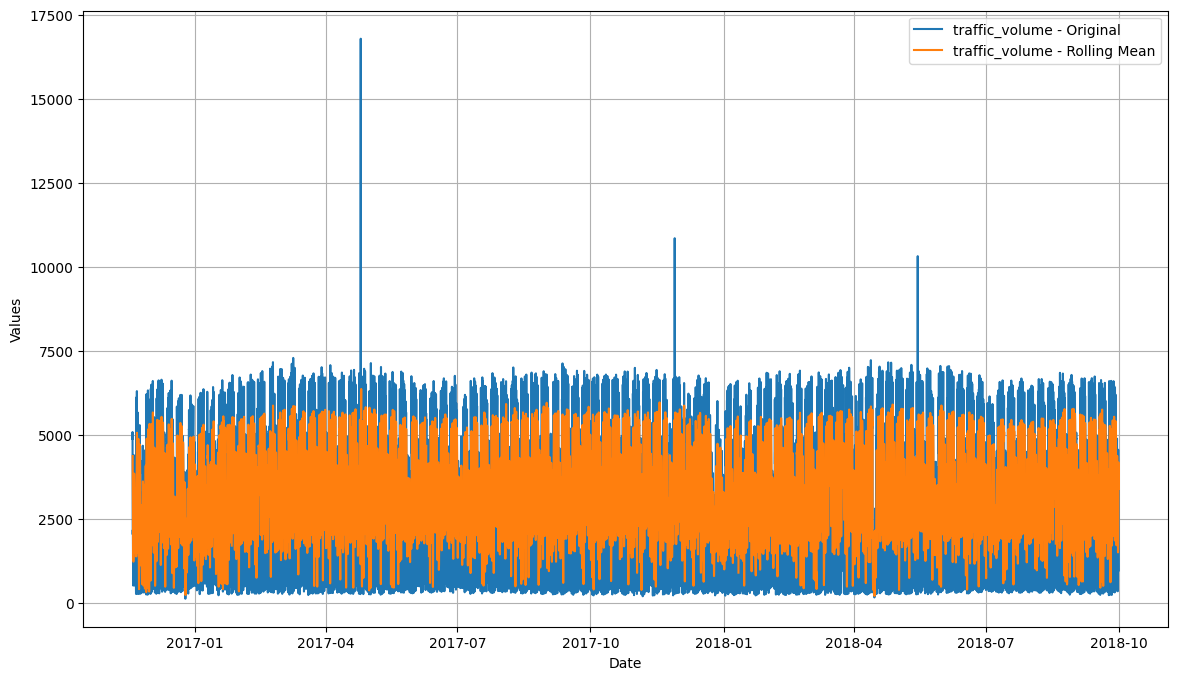

In [287]:
plt.figure(figsize=(14, 8))

# Plot original data
plt.plot(df.index, df["traffic_volume"], label=f'{"traffic_volume"} - Original')

# Compute rolling mean
rolling_mean = df["traffic_volume"].rolling(window=12).mean()
plt.plot(df.index, rolling_mean, label=f'{"traffic_volume"} - Rolling Mean')

plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


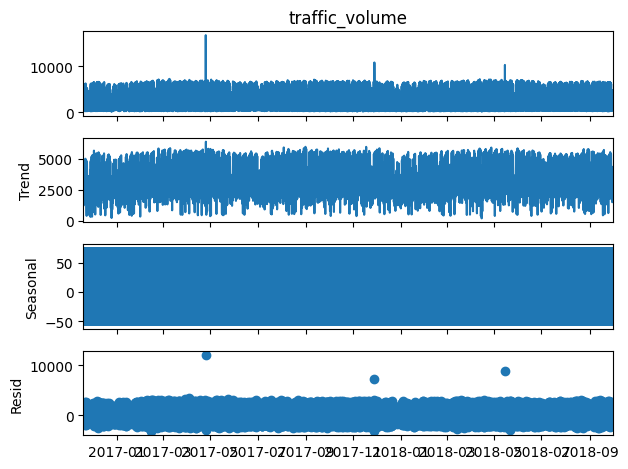

In [288]:
decomposition = seasonal_decompose(df['traffic_volume'].dropna(), model='additive', period=12)
decomposition.plot()
plt.show()

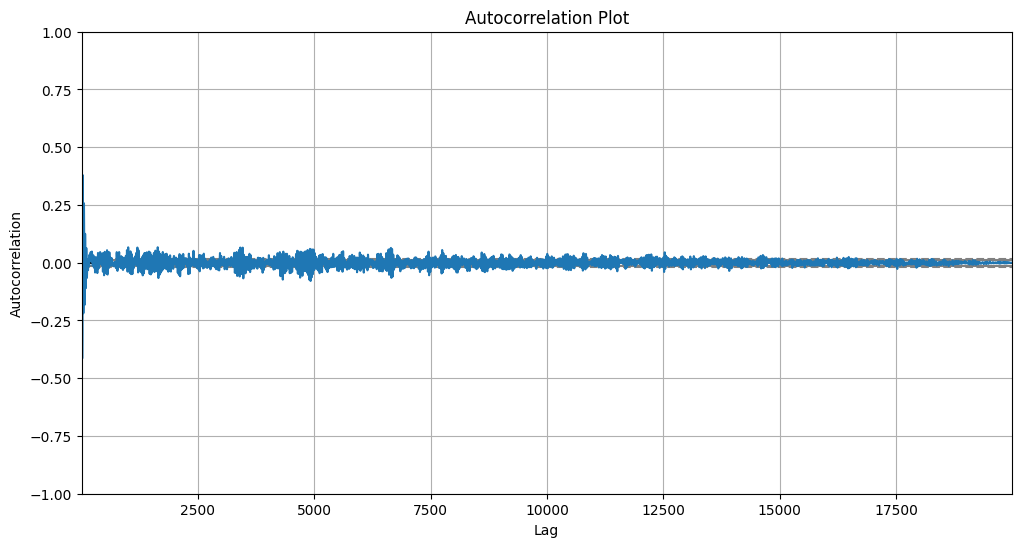

In [289]:
plt.figure(figsize=(12, 6))
autocorrelation_plot(df['traffic_volume'].dropna())
plt.title('Autocorrelation Plot')
plt.show()


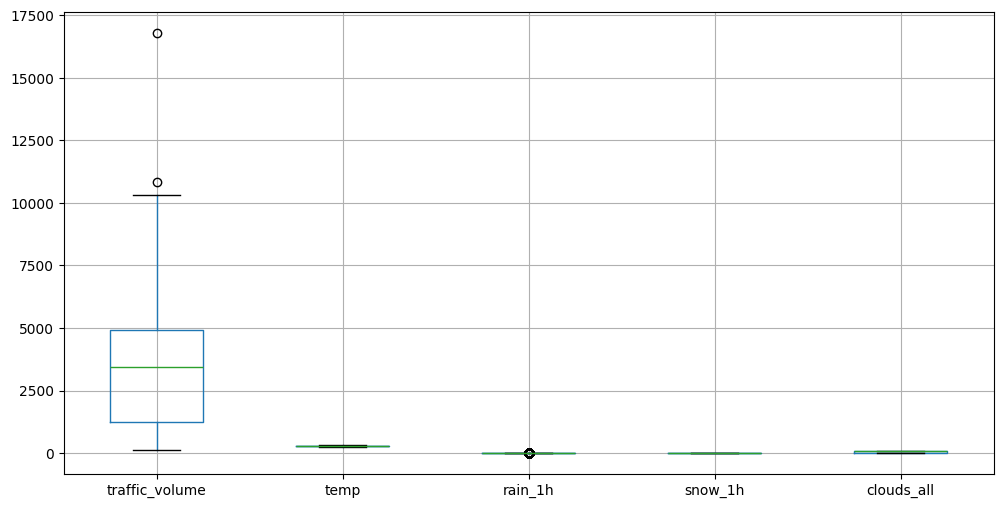

In [290]:
plt.figure(figsize=(12, 6))
df.boxplot()
plt.show()


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [291]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer_mean = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer_mean.fit_transform(df[numerical_cols])
df.isnull().sum()

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
dtype: int64

In [292]:
label_encoder = LabelEncoder()

df_encoded = df.copy()
for column in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

df_encoded


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90.0,8,9
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90.0,3,4
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90.0,5,16
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90.0,3,4
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90.0,5,16
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75.0,1,1
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90.0,1,18
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90.0,9,20


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [293]:
df_encoded['Prev_traffic_volume'] = df_encoded['traffic_volume'].shift(1)

In [294]:
#Difference between traffic_volume
df_encoded['traffic_volume_Diff'] = df_encoded['traffic_volume'].diff()

In [295]:
#Date Features
df_encoded['Day_of_Week'] = df.index.dayofweek
df_encoded['Month'] = df.index.month
df_encoded['IsWeekend'] = df.index.dayofweek >= 5

In [296]:
df_encoded["snow_1h"].unique()

array([0.])

In [297]:
df_encoded.drop(columns=['snow_1h'], inplace=True)

<Axes: >

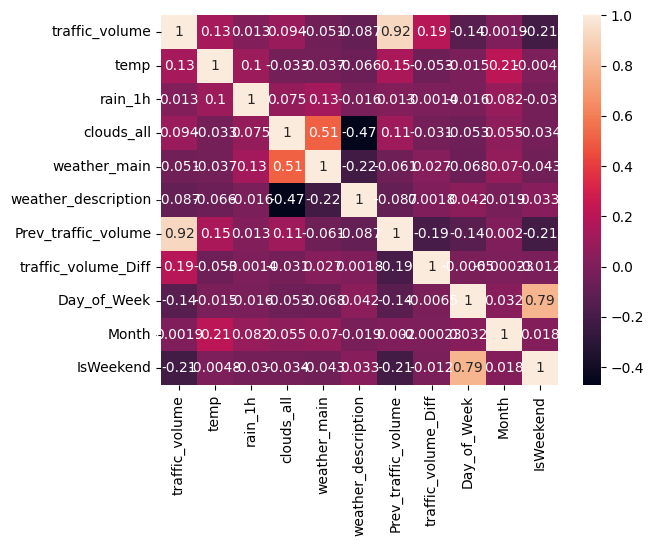

In [298]:
sns.heatmap(df_encoded.corr(), annot=True)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [299]:
split_ratio = 0.8  # 80%
split_index = int(len(df_encoded) * split_ratio)

# Split the data
train_df = df_encoded.iloc[:split_index]
test_df = df_encoded.iloc[split_index:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [300]:
scaler = StandardScaler()

scaled_train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
scaled_test_df = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [301]:
# RNN model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  
X_train, y_train = create_sequences(scaled_train_df['traffic_volume'].values, sequence_length)
X_test, y_test = create_sequences(scaled_test_df['traffic_volume'].values, sequence_length)

rnn_model = Sequential()
rnn_model.add(SimpleRNN(200, activation='relu', input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer=Adam(), loss='mean_squared_error')

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [302]:
history_rnn = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1550 - val_loss: 0.0860
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0636 - val_loss: 0.0869
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0598 - val_loss: 0.0759
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0611 - val_loss: 0.0786
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0624 - val_loss: 0.0777
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0534 - val_loss: 0.0746
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0560 - val_loss: 0.0660
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0514 - val_loss: 0.0669
Epoch 9/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0518 - val_loss: 0.0649
Epoch 10/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0505 - val_loss: 0.0601
Epoch 11/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0519 - val_loss: 0.0621
Epoch 12/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [303]:
rnn_model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497


0.047444459050893784

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [304]:
y_pred_rnn = rnn_model.predict(X_test)

mae_rnn = mean_absolute_error(y_test, y_pred_rnn)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test - y_pred_rnn) / y_test)) * 100

print(f'RNN Model - MAE: {mae_rnn}, MSE: {mse_rnn}, RMSE: {rmse_rnn}, MAPE: {mape_rnn}%')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RNN Model - MAE: 0.147447284984126, MSE: 0.04744446460581134, RMSE: 0.2178175029831426, MAPE: 493.8827444997445%


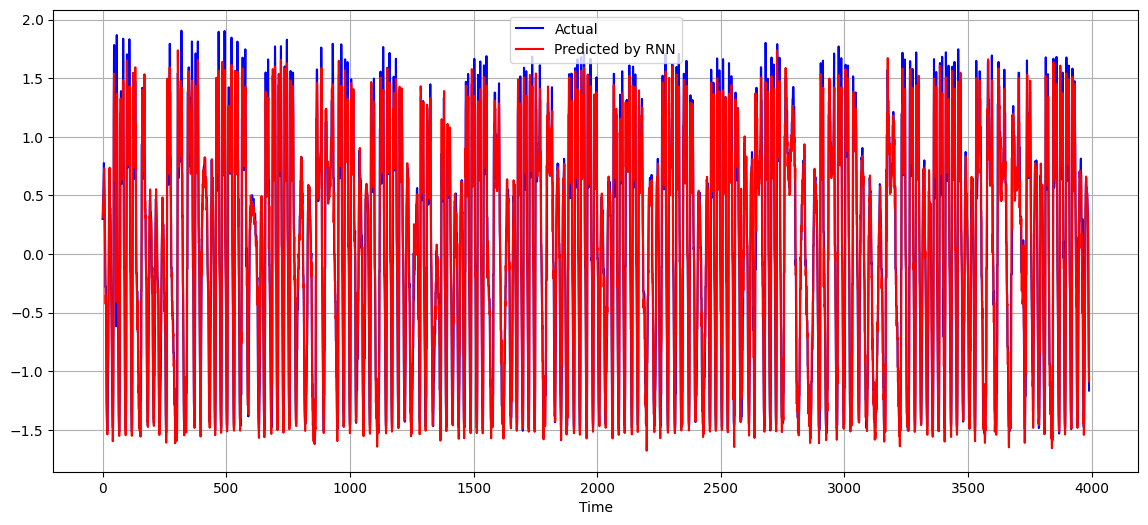

In [305]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_rnn, label='Predicted by RNN', color='red')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

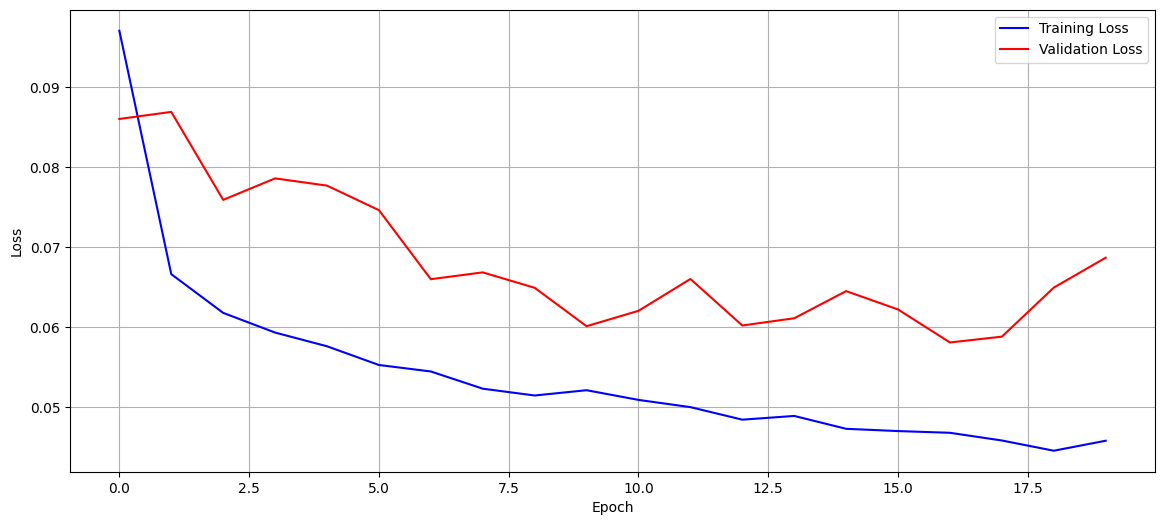

In [306]:
plt.figure(figsize=(14, 6))
plt.plot(history_rnn.history['loss'], label='Training Loss', color='blue')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [307]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [308]:
history_lstm= lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3101 - val_loss: 0.1445
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0953 - val_loss: 0.1122
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0876 - val_loss: 0.1075
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0738 - val_loss: 0.0936
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0711 - val_loss: 0.0916
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0673 - val_loss: 0.0829
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0611 - val_loss: 0.0813
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0610 - val_loss: 0.0797
Epoch 9/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0619 - val_loss: 0.0792
Epoch 10/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0555 - val_loss: 0.0762
Epoch 11/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0574 - val_loss: 0.0779
Epoch 12/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [309]:
y_pred_lstm = lstm_model.predict(X_test)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm) / y_test)) * 100
print(f'LSTM Model - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}, MAPE: {mape_lstm}%')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
LSTM Model - MAE: 0.14325808703114573, MSE: 0.04513824737877265, RMSE: 0.21245763666851952, MAPE: 508.86356413756306%


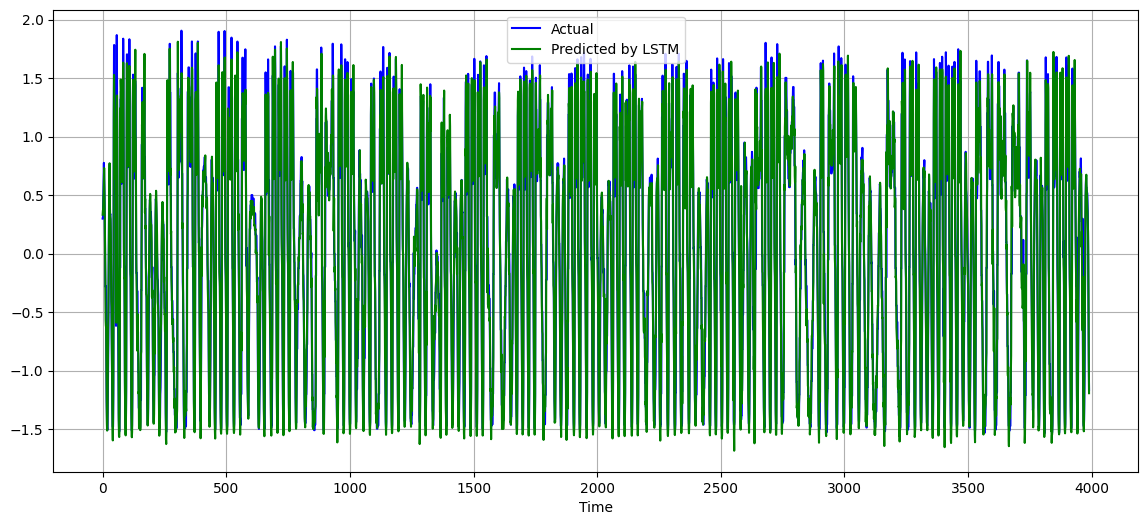

In [310]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_lstm, label='Predicted by LSTM', color='green')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

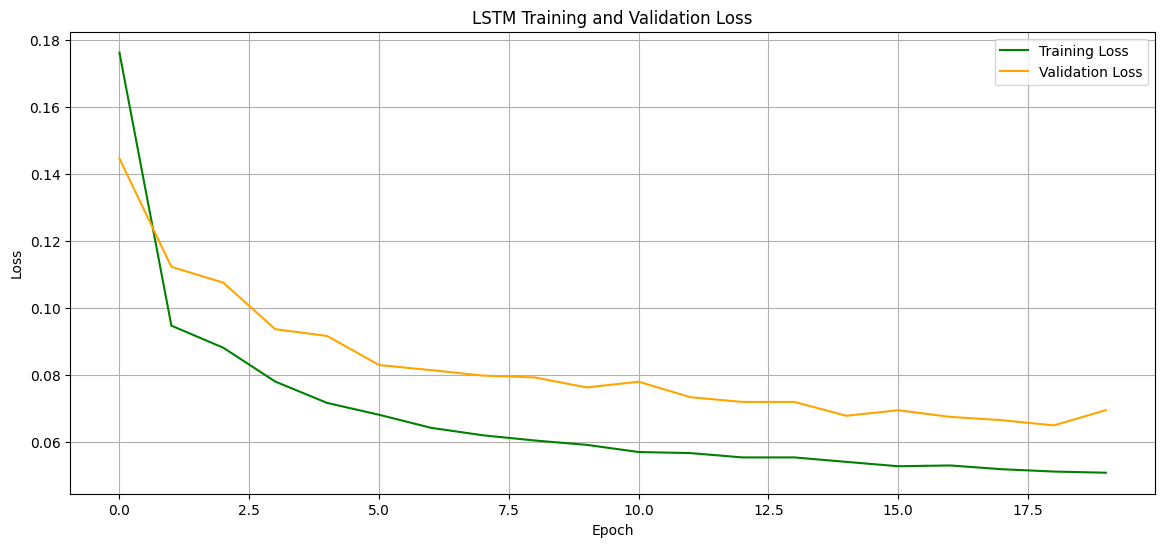

In [311]:
plt.figure(figsize=(14, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss', color='green')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1. i used LabelEncoder for encoding the data and StandardScaler to make the data smaller to not use too much comput power 
2. i dropped snow_1h because it had the same value and added day and munth and i added one more IsWeekend because i think its important for the model i did not add Day_of_Year because it was the same is Month
3. i used 2 models RNN and LSTM i used for both 200 node 
4. from my testing i used a batch size of 32 and 20 epochs for both models 
5. i used mean_squared_error and i used MAE, MSE, RMSE, MAPE to evaluate the model 
6. i tried multiple values for testing and i found the value i used are the best for the model
7. the RNN is not over no under fitted but the LSTM is a late overfitted and i should lower the barometer for it but i keep it the same to match the RNN
8. i should test more models like ARIMA, SARIMA and i should lower the barometer for LSTM or important early stopping 